### 1. Library

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
try:
    from xgboost import XGBClassifier
    _XGB_OK = True
except ImportError:
    _XGB_OK = False
try:
    from lightgbm import LGBMClassifier
    _LGB_OK = True
except ImportError:
    _LGB_OK = False
try:
    from catboost import CatBoostClassifier
    _CAT_OK = True
except ImportError:
    _CAT_OK = False
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

### Buka Dataset

In [2]:
train=pd.read_csv("C:/Users/VICTUS/Documents/.A/Semester 5/SML/Tugas Kaggle/Dataset/train.csv")
test=pd.read_csv("C:/Users/VICTUS/Documents/.A/Semester 5/SML/Tugas Kaggle/Dataset/test.csv")

### 3.Menentukan Kolom ID dan Target, Serta menghapus kolom konstan

In [13]:
_label = next((c for c in train.columns if 'attrition' in c.lower()), None)
_idcol = next((c for c in train.columns if c.lower() == 'id' or 'employee' in c.lower()), None)

Y = train[_label].copy()
A = train.drop(columns=[_label] + ([_idcol] if _idcol in train.columns else []))
A_test = test.drop(columns=[_idcol] if _idcol in test.columns else [], errors='ignore')
test_ids = test[_idcol].copy() if _idcol in test.columns else pd.Series(np.arange(len(test)), name='id')
const_cols = [c for c in A.columns if A[c].nunique() <= 1]
if const_cols:
    A.drop(columns=const_cols, inplace=True)
    A_test.drop(columns=const_cols, inplace=True)

### 4.Cek Duplikat dan Missing Value

In [14]:
df_full = pd.concat([train.drop(_label, axis=1), test], ignore_index=True)

# Missing Values
print("\n[Missing Values Check]")
missing_report = df_full.isnull().sum()
missing_report = missing_report[missing_report > 0]
if not missing_report.empty:
    print(missing_report.sort_values(ascending=False))
else:
    print("Tidak ditemukan missing values.")

# Duplikasi
print("\n[Duplikasi Check]")
duplicate_count = df_full.duplicated().sum()
print(f"Jumlah baris duplikat: {duplicate_count}")


[Missing Values Check]
Tidak ditemukan missing values.

[Duplikasi Check]
Jumlah baris duplikat: 0


### 5.Pembagian Data Kategorik dan Numerik 

In [8]:
numerical_cols = df_full.select_dtypes(include=np.number).columns.tolist()
# Hapus kolom ID/konstan/redundant dari analisis distribusi
cols_to_exclude = ['id', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'] 
numerical_cols = [c for c in numerical_cols if c not in cols_to_exclude]

categorical_cols = df_full.select_dtypes(include='object').columns.tolist()
# Tambahkan variabel biner/ordinal yang direpresentasikan sebagai angka (mis. JobLevel)
ordinal_or_binary_num = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 
                         'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 
                         'StockOptionLevel', 'WorkLifeBalance']

# Gabungkan kolom numerik dan ordinal/biner yang akan dianalisis
final_numerical_cols = list(set(numerical_cols) - set(ordinal_or_binary_num))
final_categorical_cols = categorical_cols + ordinal_or_binary_num

### 6.Quick EDA

Distribusi Variabel Numerik

Distribusi Variabel Numerik (Histogram)


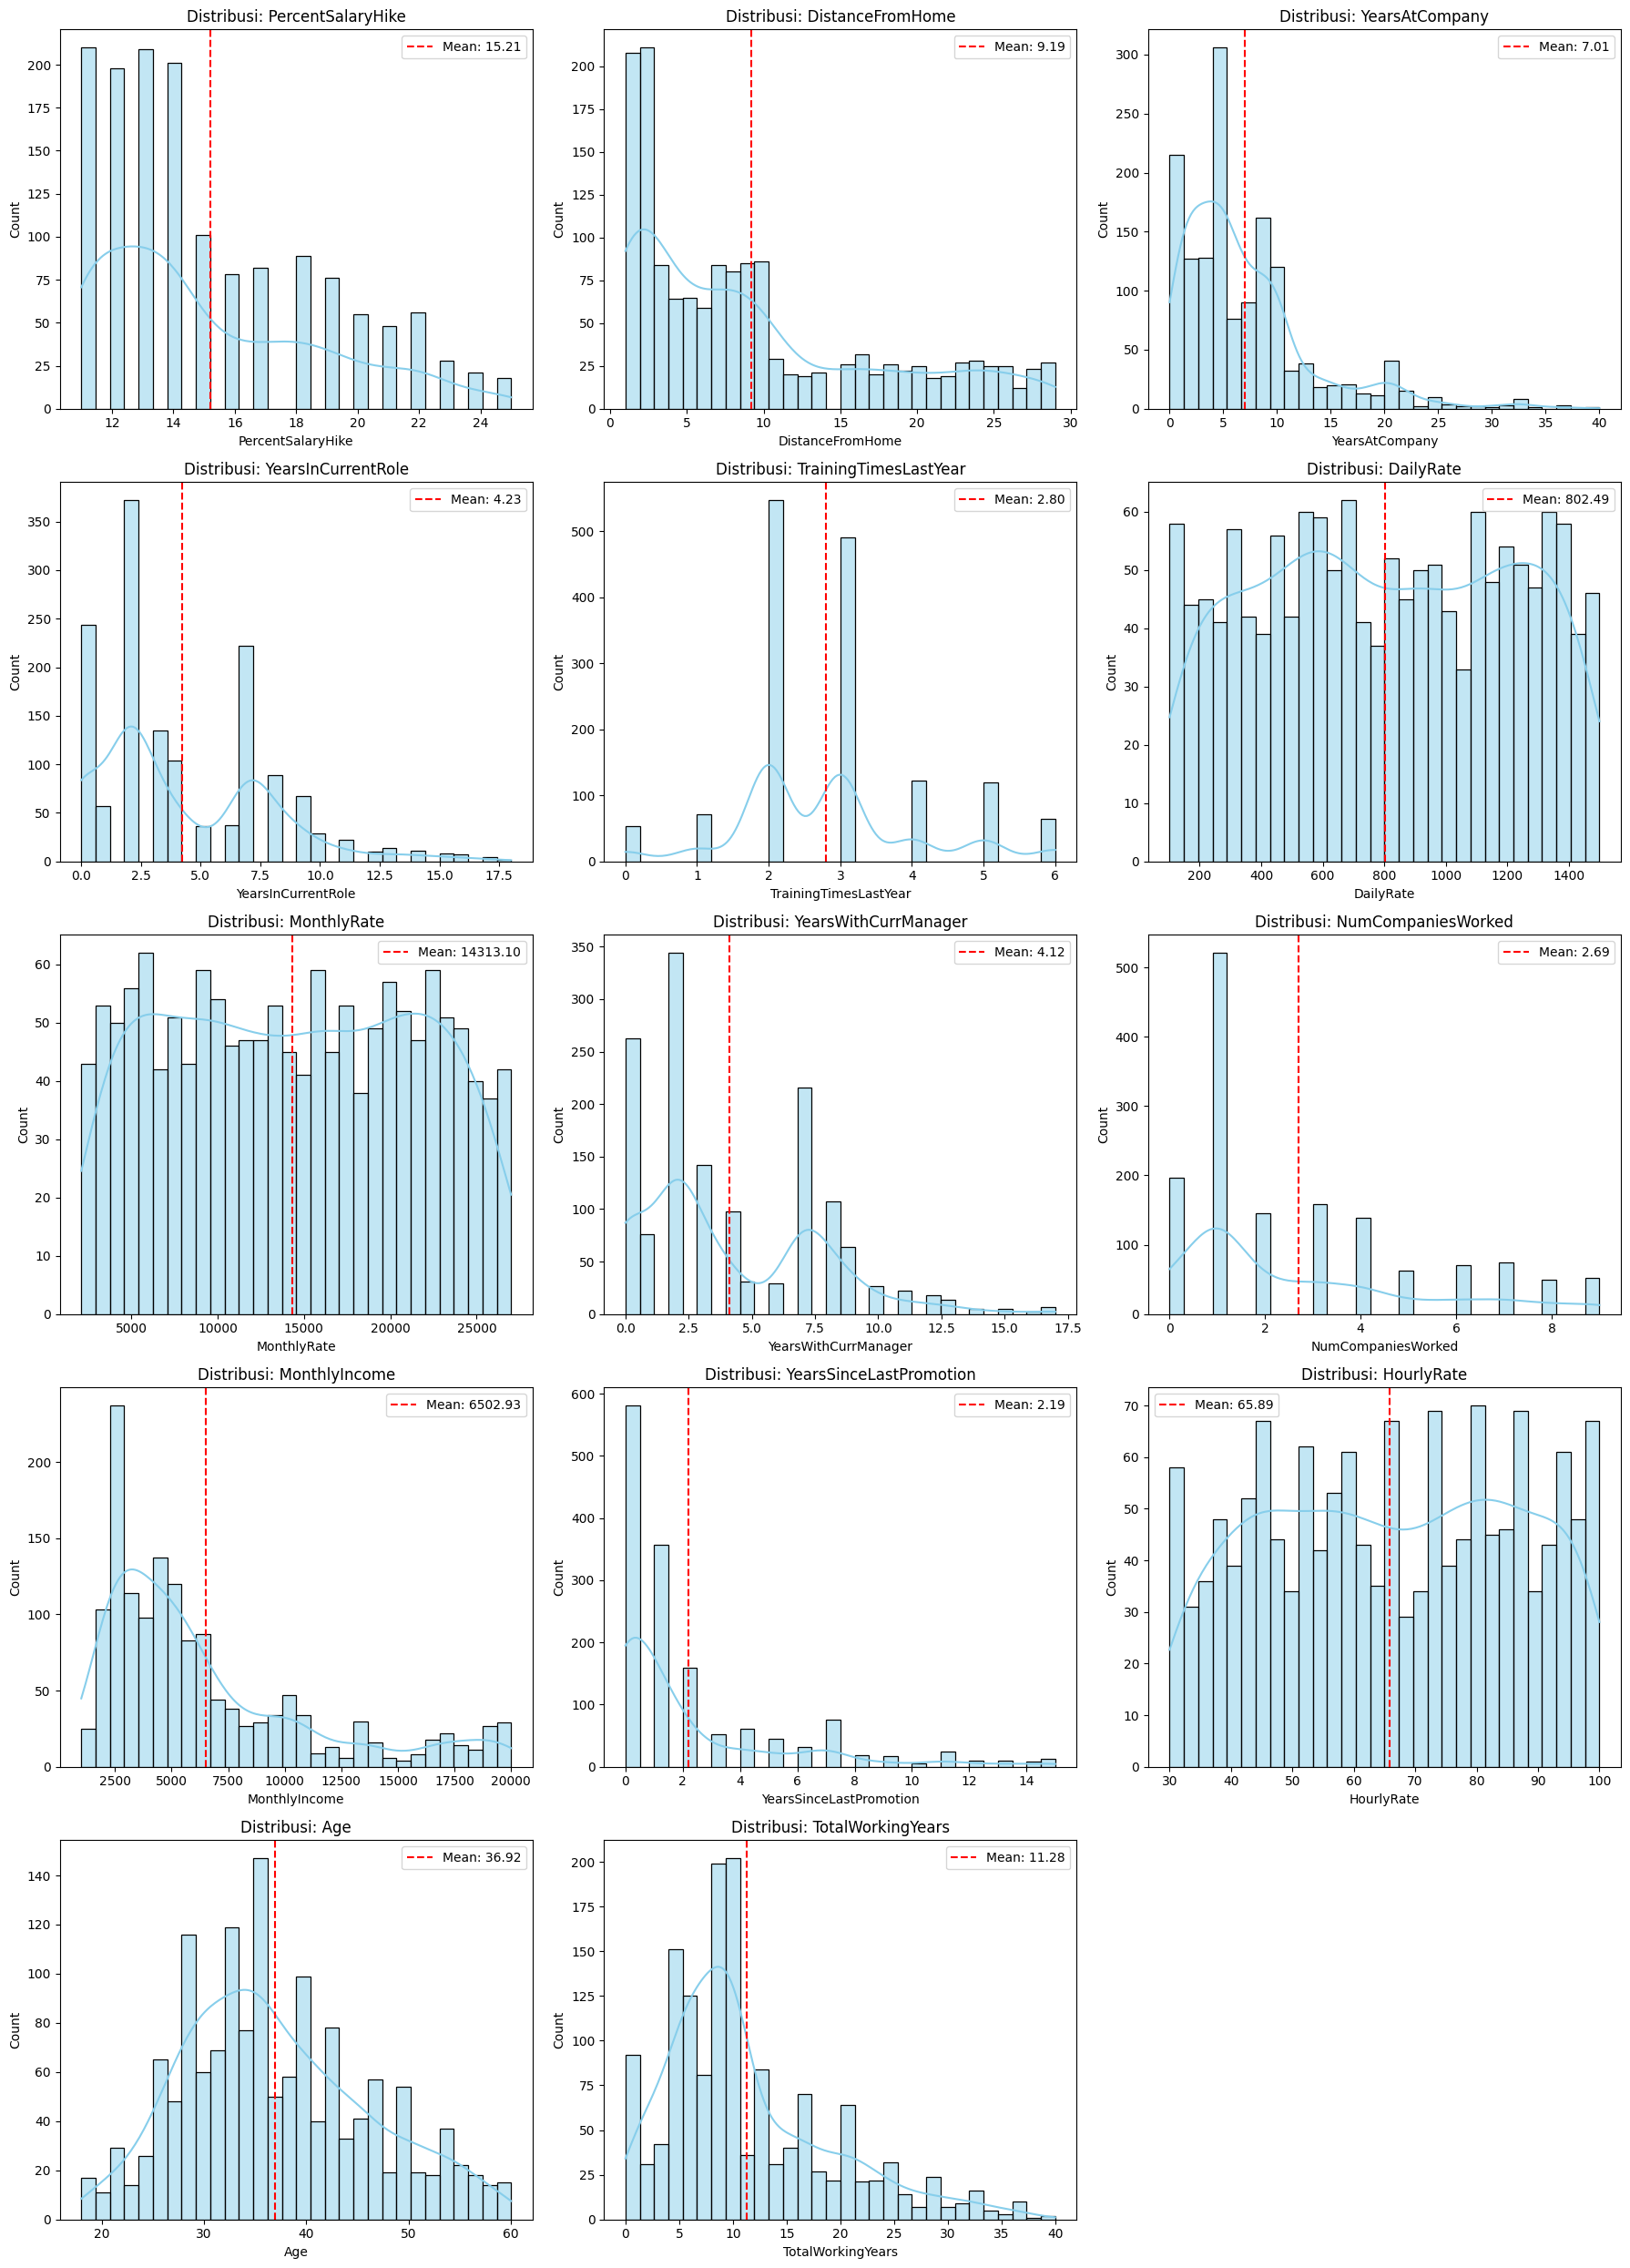

In [11]:

print("Distribusi Variabel Numerik (Histogram)")
n_rows = (len(final_numerical_cols) + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(final_numerical_cols):
    sns.histplot(df_full[col], kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribusi: {col}')
    axes[i].axvline(df_full[col].mean(), color='red', linestyle='--', label=f'Mean: {df_full[col].mean():.2f}')
    axes[i].legend()

# Hapus subplot yang tidak terpakai
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Distribusi Variabel Kategorik


Distribusi Variabel Kategorikal 


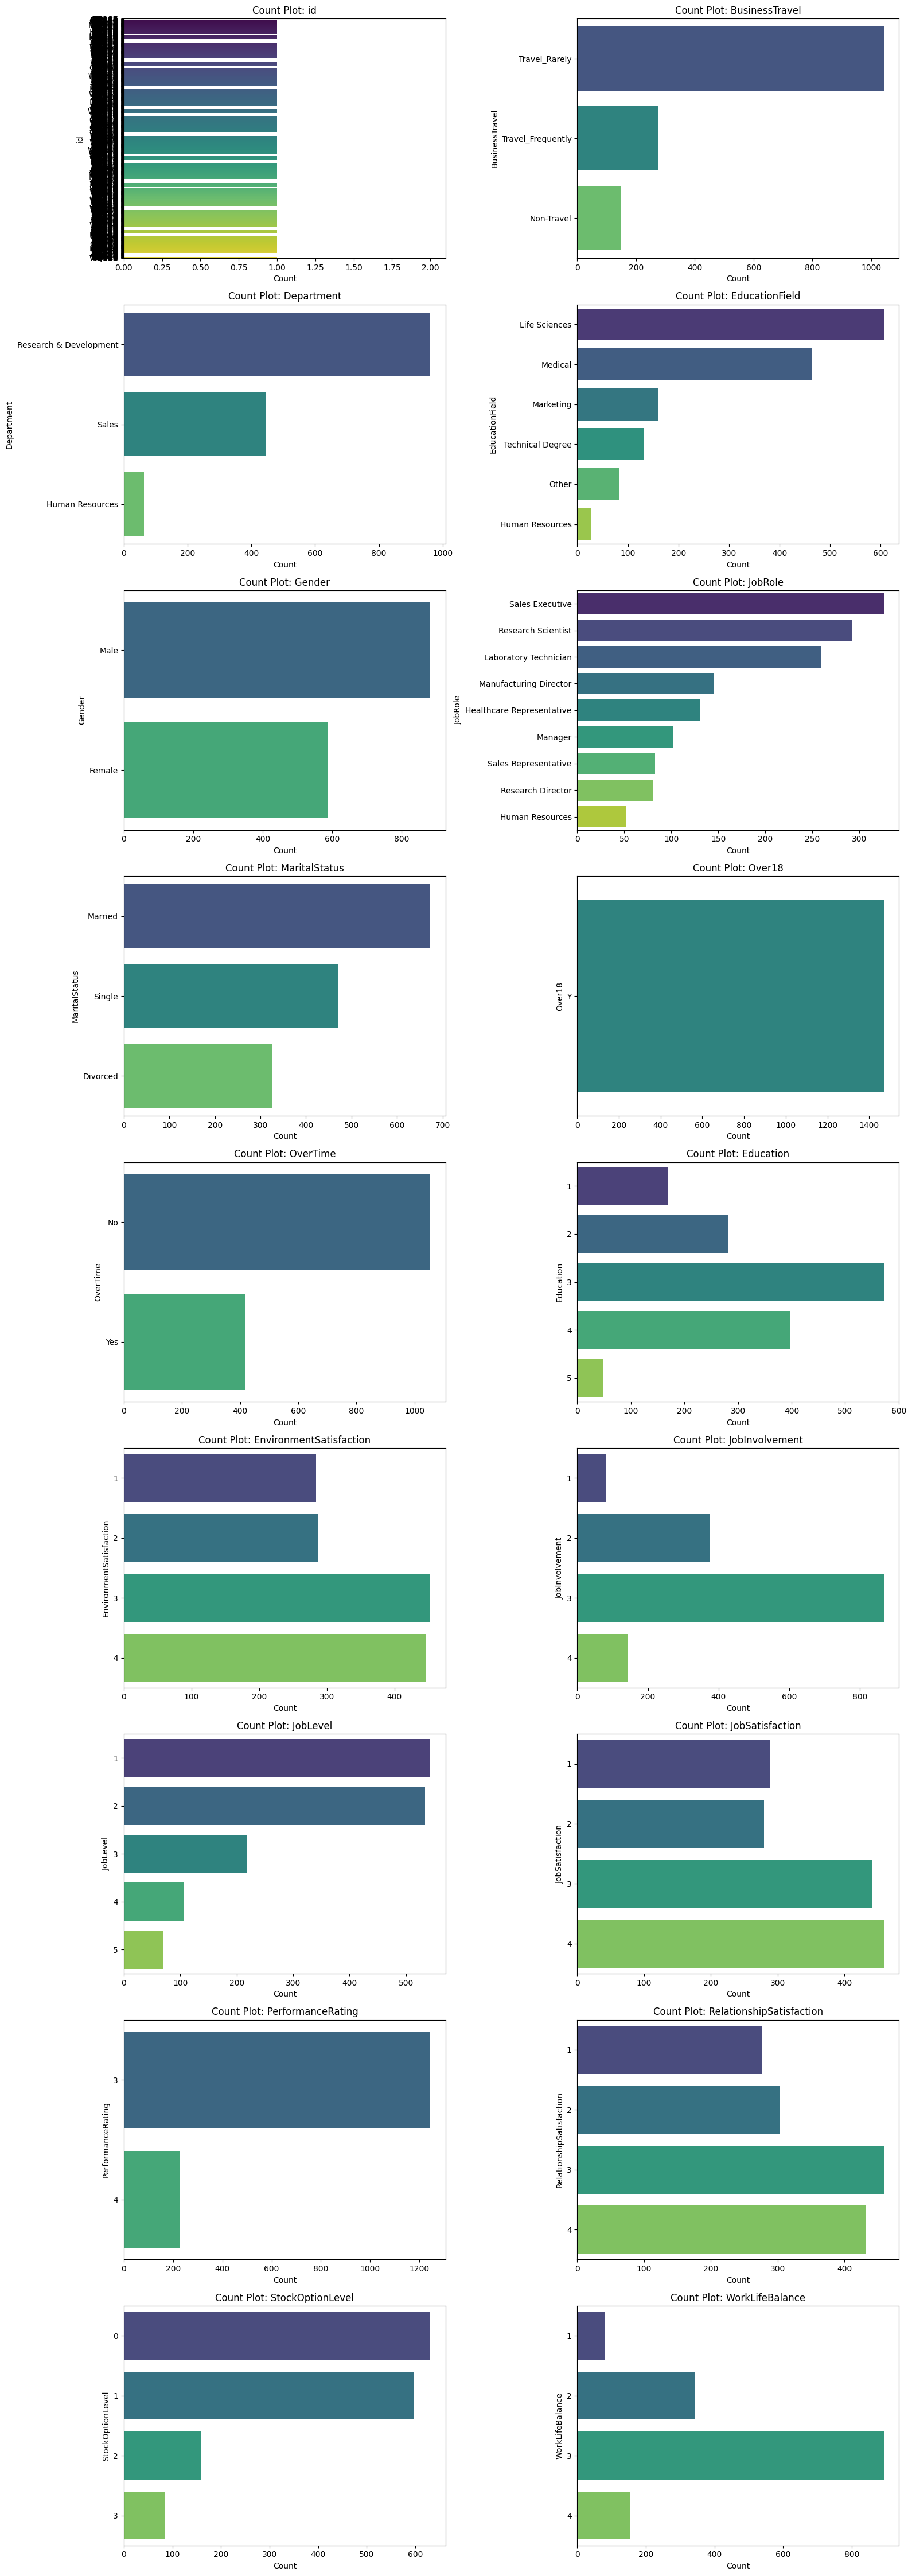

In [12]:
print("\nDistribusi Variabel Kategorikal ")
n_rows_cat = (len(final_categorical_cols) + 1) // 2
fig, axes_cat = plt.subplots(n_rows_cat, 2, figsize=(16, 5 * n_rows_cat))
axes_cat = axes_cat.flatten()

for i, col in enumerate(final_categorical_cols):
    # Urutkan berdasarkan nilai unik untuk variabel ordinal
    if col in ordinal_or_binary_num:
        order = sorted(df_full[col].unique())
    else:
        # Urutkan berdasarkan frekuensi untuk variabel nominal
        order = df_full[col].value_counts().index
        
    sns.countplot(y=df_full[col], order=order, ax=axes_cat[i], palette='viridis')
    axes_cat[i].set_title(f'Count Plot: {col}')
    axes_cat[i].set_xlabel('Count')

# Hapus subplot yang tidak terpakai
for j in range(i + 1, len(axes_cat)):
    fig.delaxes(axes_cat[j])

plt.tight_layout()
plt.show()


### 7.Feature Engineering

In [15]:
def make_derived_features(df):
    B = df.copy()
    
    # A. Transformasi Log (Stabilisasi)
    B['MonthlyIncome_Log'] = np.log1p(B.get('MonthlyIncome', 0))
    B['TotalWorkingYears_Log'] = np.log1p(B.get('TotalWorkingYears', 0))

    # B. Domain Ratios & Stabilitas
    B['LoyaltyIndex'] = B.get('YearsAtCompany', 0) / (B.get('TotalWorkingYears', 0) + 1e-6)
    B['role_share'] = B.get('YearsInCurrentRole', 0) / (B.get('YearsAtCompany', 0) + 1e-6)
    B['manager_share'] = B.get('YearsWithCurrManager', 0) / (B.get('YearsAtCompany', 0) + 1e-6)
    B['job_turnover_rate'] = B.get('NumCompaniesWorked', 0) / (B.get('TotalWorkingYears', 0) + 1e-6)
    
    # C. Satisfaction Aggregates
    satis_cols = ['EnvironmentSatisfaction','JobSatisfaction','RelationshipSatisfaction','WorkLifeBalance']
    B['mean_satis'] = B[satis_cols].mean(axis=1)
    B['low_satis_flag'] = (B['mean_satis'] < 2.0).astype(int) 
    
    # D. Interaction Features
    B['income_div_level'] = B.get('MonthlyIncome', 0) / (B.get('JobLevel', 0) + 1e-6)
    
    # E. Flags
    ot_val = B.get('OverTime', 0)
    if not np.issubdtype(ot_val.dtype, np.number):
        ot_val = ot_val.astype(str).str.lower().isin(['yes','y','true','1'])
    B['flag_overtime'] = ot_val.astype(int)
    
    # Hapus kolom asli yang sudah ditransformasi/redundant
    B = B.drop(columns=['MonthlyIncome', 'TotalWorkingYears'], errors='ignore')
    
    return B

A_eng = make_derived_features(A)
A_test_eng = make_derived_features(A_test)

### 8. Encoding

In [16]:
cat_cols = A_eng.select_dtypes(include=['object', 'category']).columns.tolist()
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([A_eng[col].astype(str), A_test_eng[col].astype(str)], axis=0)
    le.fit(combined)
    A_eng[col] = le.transform(A_eng[col].astype(str))
    A_test_eng[col] = le.transform(A_test_eng[col].astype(str))
    encoders[col] = le

X_train_full = A_eng.copy()
X_test_full = A_test_eng.copy()

### 9.Split Data & Scaling

In [17]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, Y, test_size=0.2, stratify=Y, random_state=2025
)

scaler2 = StandardScaler()
X_tr_sc = scaler2.fit_transform(X_tr)
X_val_sc = scaler2.transform(X_val)
X_test_sc = scaler2.transform(X_test_full)

### 10. Model Training Helper

In [18]:
results_map = {}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def fit_and_eval(tag, estimator, use_scaled=False):
    print(f"\nTraining: {tag}")
    X_fit = X_tr_sc if use_scaled else X_tr.values
    y_fit = y_tr
    X_valid = X_val_sc if use_scaled else X_val.values

    estimator.fit(X_fit, y_fit)
    prob_val = estimator.predict_proba(X_valid)[:,1]

    val_auc = roc_auc_score(y_val, prob_val)

    # Cross-Validation Score (digunakan sebagai bobot)
    try:
        cv_scores = cross_val_score(estimator, X_tr_sc if use_scaled else X_tr, y_tr, cv=kf, scoring='roc_auc', n_jobs=-1)
        cv_mean, cv_std = cv_scores.mean(), cv_scores.std()
    except Exception:
        cv_mean, cv_std = val_auc, 0.0

    print(f" Val AUC: {val_auc:.4f}, CV: {cv_mean:.4f} ± {cv_std:.4f}")

    results_map[tag] = {
        'est': estimator, 'val_auc': val_auc,
        'cv': cv_mean, 'cv_std': cv_std, 'val_pred': prob_val, 'scaled': use_scaled
    }

### 11. Train BaseModel

In [22]:
fit_and_eval("LR_L2", LogisticRegression(max_iter=2000, C=0.03, penalty='l2', class_weight='balanced', random_state=42), use_scaled=True)
# Tree-based
fit_and_eval("RF_big", RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_leaf=12, class_weight='balanced', random_state=42, n_jobs=-1), use_scaled=False)
fit_and_eval("ET_big", ExtraTreesClassifier(n_estimators=450, max_depth=8, min_samples_leaf=12, random_state=42, n_jobs=-1), use_scaled=False)
# Boosting (Tuning Agresif)
fit_and_eval("GB_skl", GradientBoostingClassifier(n_estimators=250, learning_rate=0.03, max_depth=4, subsample=0.75, random_state=42), use_scaled=False)

if _XGB_OK:
    fit_and_eval("XG_boost", XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=5, 
                                          subsample=0.75, colsample_bytree=0.75, random_state=42, 
                                          use_label_encoder=False, eval_metric='logloss'), 
                 use_scaled=False)
if _LGB_OK:
    fit_and_eval("LGB_boost", LGBMClassifier(n_estimators=500, learning_rate=0.02, max_depth=5, 
                                            num_leaves=24, subsample=0.75, colsample_bytree=0.75, 
                                            random_state=42, n_jobs=-1, verbose=-1), 
                 use_scaled=False)
if _CAT_OK:
    fit_and_eval("CAT_boost", CatBoostClassifier(iterations=500, learning_rate=0.02, depth=5, 
                                                random_state=42, verbose=False), 
                 use_scaled=False)



Training: LR_L2
 Val AUC: 0.8072, CV: 0.8122 ± 0.0561

Training: RF_big
 Val AUC: 0.7562, CV: 0.7982 ± 0.0508

Training: ET_big
 Val AUC: 0.7516, CV: 0.8055 ± 0.0485

Training: GB_skl
 Val AUC: 0.7976, CV: 0.8030 ± 0.0520

Training: XG_boost
 Val AUC: 0.8089, CV: 0.8018 ± 0.0497


### 12.Kalibrasi

In [23]:
summary_df = pd.DataFrame([
    { 'Model': k, 'TrainAUC': v['est'].score(X_tr.values if not v['scaled'] else X_tr_sc, y_tr), 'ValAUC': v['val_auc'], 'CV': v['cv'], 'Gap': v['est'].score(X_tr.values if not v['scaled'] else X_tr_sc, y_tr) - v['val_auc'] } 
    for k,v in results_map.items()
]).sort_values('CV', ascending=False).reset_index(drop=True)

top_by_cv = summary_df.nlargest(5, 'CV')['Model'].tolist()
print("\nCalibrating top (by CV AUC):", top_by_cv)

calibrated_dict = {}
for tag in top_by_cv:
    item = results_map[tag]
    est = item['est']
    
    X_for_fit = X_tr_sc if item['scaled'] else X_tr.values
    y_for_fit = y_tr
    
    # Gunakan cv=5 untuk kalibrasi yang lebih stabil
    calib_clf = CalibratedClassifierCV(est, method='isotonic', cv=5) 
    calib_clf.fit(X_for_fit, y_for_fit)
    
    X_val_fit = X_val_sc if item['scaled'] else X_val.values
    
    pred_val = calib_clf.predict_proba(X_val_fit)[:,1]
    calib_auc = roc_auc_score(y_val, pred_val)
    print(f"  {tag}: calib AUC {calib_auc:.4f} (orig {item['val_auc']:.4f})")
    calibrated_dict[f"{tag}_CAL"] = {'clf': calib_clf, 'val_auc': calib_auc, 'pred': pred_val, 'scaled': item['scaled']}


Calibrating top (by CV AUC): ['LR_L2', 'ET_big', 'GB_skl', 'XG_boost', 'RF_big']
  LR_L2: calib AUC 0.8244 (orig 0.8072)
  ET_big: calib AUC 0.7508 (orig 0.7516)
  GB_skl: calib AUC 0.8071 (orig 0.7976)
  XG_boost: calib AUC 0.8138 (orig 0.8089)
  RF_big: calib AUC 0.7630 (orig 0.7562)


### 13.Final Weighted Ensemble

In [24]:
ensemble_members = summary_df.nlargest(3, 'CV')['Model'].tolist() # 3 model CV terbaik
for k in calibrated_dict.keys():
    if calibrated_dict[k]['val_auc'] > 0.77: # Tambahkan versi kalibrasi yang berguna
        ensemble_members.append(k)

ensemble_members = list(set(ensemble_members))
print("\nFinal ensemble members:", ensemble_members)

pred_list = []
wt_list = []
for m in ensemble_members:
    if m in results_map:
        pred_list.append(results_map[m]['val_pred'])
        wt_list.append(results_map[m]['cv']) # Bobot menggunakan CV score (paling stabil)
    else:
        pred_list.append(calibrated_dict[m]['pred'])
        wt_list.append(calibrated_dict[m]['val_auc']) # Bobot menggunakan Val AUC Kalibrasi

wt_arr = np.array(wt_list) / np.sum(wt_list)
stacked_wavg = np.average(pred_list, axis=0, weights=wt_arr)
score_wt = roc_auc_score(y_val, stacked_wavg)
print(f"Ensemble (Weighted Average) AUC: {score_wt:.4f}")



Final ensemble members: ['ET_big', 'GB_skl', 'XG_boost_CAL', 'LR_L2', 'GB_skl_CAL', 'LR_L2_CAL']
Ensemble (Weighted Average) AUC: 0.8099


### 14. Final Prediction & Submission

In [25]:
test_preds_map = {}
for m in ensemble_members:
    if m in results_map:
        model_obj = results_map[m]['est']
        sc_flag = results_map[m]['scaled']
    else:
        model_obj = calibrated_dict[m]['clf']
        sc_flag = calibrated_dict[m]['scaled']
    
    # Gunakan data test yang sesuai (scaled atau raw)
    Xt = X_test_sc if sc_flag else X_test_full.values
    preds_m = model_obj.predict_proba(Xt)[:,1]
    test_preds_map[m] = preds_m

# Weighted average for test
test_preds_stack = np.column_stack([test_preds_map[m] for m in ensemble_members])
final_scores = np.average(test_preds_stack, axis=1, weights=wt_arr)

submission_df = pd.DataFrame({ 'id': test_ids, 'Attrition': final_scores })
submission_df.to_csv('submission.csv', index=False)


### 15.Simpan Model

In [27]:
with open('submission.pkl', 'wb') as file:
    pickle.dump(submission_df, file)
